<a href="https://colab.research.google.com/github/DerekGloudemans/segmentation-medical-images/blob/master/2D_Slice_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminaries

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
#%%capture 
!pip install -q --upgrade ipython==5.5.0
!pip install -q --upgrade ipykernel==4.6.0
!pip3 install torchvision
!pip3 install opencv-python

import ipywidgets
import traitlets

In [0]:
# imports

# this seems to be a popular thing to do so I've done it here
#from __future__ import print_function, division


# torch and specific torch packages for convenience
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
from torch import multiprocessing
from google.colab.patches import cv2_imshow

# for convenient data loading, image representation and dataset management
from torchvision import models, transforms
import torchvision.transforms.functional as FT
from PIL import Image, ImageFile, ImageStat
ImageFile.LOAD_TRUNCATED_IMAGES = True
from scipy.ndimage import affine_transform
import cv2

# always good to have
import time
import os
import numpy as np    
import _pickle as pickle
import random
import copy
import matplotlib.pyplot as plt
import math

import nibabel as nib



## Define Dataset for Dealing with NIfTI Files
(1) spleen
(2) right kidney
(3) left kidney
(4) gallbladder
(5) esophagus
(6) liver
(7) stomach
(8) aorta
(9) inferior vena cava
(10) portal vein and splenic vein
(11) pancreas
(12) right adrenal gland
(13) left adrenal gland

In [0]:
class Nifti_Dataset(data.Dataset):
  def __init__(self,mode = "view",dim = 2):
    """
    Save the last 0.15 proportion of files after sorting for use as validation set.
    Loads each slice of the input images as a separate image
    mode - view,train or val, defined in same dataset to maintain data separation
      view - performs transforms but does not normalize images
      train - normalizes data and performs transforms
      val - normalizes data, no augmenting transforms
    dim - specifies dimension along which to slice image
    """

    self.mode = mode
    self.dim = dim

    data_dir = "/content/drive/My Drive/Colab Notebooks/Segmentation/RawData/Training/img"
    label_dir = "/content/drive/My Drive/Colab Notebooks/Segmentation/RawData/Training/label"

    # get all data and label file names
    self.data_files = []
    for file in os.listdir(data_dir):
      self.data_files.append(os.path.join(data_dir,file))
    self.data_files.sort()

    self.label_files = []
    for file in os.listdir(label_dir):
      self.label_files.append(os.path.join(label_dir,file))
    self.label_files.sort()

    # for each data_file
    self.train_data = []
    self.val_data = []

    for i in range(len(self.data_files)):
      data = nib.load(self.data_files[i])
      data = np.array(data.get_fdata())

      label = nib.load(self.label_files[i])
      label = np.array(label.get_data())

      identifier = self.data_files[i].split("_")[0]
      for slice in range(0,data.shape[dim]):

        # get slices
        if dim == 0:
          data_slice = data[slice,:,:]
          label_slice = label[slice,:,:]
        elif dim == 1:
          data_slice = data[:,slice,:]
          label_slice = label[:,slice,:]
        elif dim == 2:
          data_slice = data[:,:,slice]
          label_slice = label[:,:,slice]

        mean,std = np.mean(data_slice),np.std(data_slice)
        # define item dict to store info
        item = {
            "identifier":identifier,
            "slice":slice,
            "data":data_slice,
            "label":label_slice,
            "mean":mean,
            "std":std
            }

        # assign to either training or validation data
        if i < len(self.data_files) * 0.85:
          self.train_data.append(item)
        else:
          self.val_data.append(item)

      #break # to shorten loading time

    # define some transforms for training dataset
    self.train_transforms = transforms.Compose([
          transforms.ColorJitter(brightness = 0.2,contrast = 0.2,saturation = 0.1),
          transforms.ToTensor(),
          transforms.RandomErasing(p=0.15, scale=(0.4, 0.6), ratio=(0.3, 3.3), value=0, inplace=False), # big
          transforms.RandomErasing(p=0.3, scale=(0.1, 0.3), ratio=(0.3, 3.3), value=0, inplace=False), # medium
          transforms.RandomErasing(p=0.4, scale=(0.05, 0.15), ratio=(0.3, 3.3), value=0, inplace=False),# small
          transforms.RandomErasing(p=0.35, scale=(0.05, 0.2), ratio=(0.3, 3.3), value=0, inplace=False) # small
          

        ])

  def __getitem__(self,index):
      #get relevant dictionary from self memory

      if self.mode in ['train','view']:
        item = self.train_data[index]
      else:
        item = self.val_data[index]

      x = Image.fromarray(item['data']).copy()
      y = Image.fromarray(item['label']).copy()

      # to grayscale
      x  = FT.to_grayscale(x)
      y = FT.to_grayscale(y)

      if self.mode in ['train','view']:
        # randomly flip and rotate both
        FLIP = np.random.rand()
        if FLIP > 0.5:
          x = FT.hflip(x)
          y = FT.hflip(y)

        ROTATE = np.random.rand() *60 - 30
        x  = x.rotate(ROTATE)
        y = y.rotate(ROTATE)

      # resize to 224 on shorter dimension
      x  = FT.resize(x, 256)
      y = FT.resize(y,256)

      if self.mode in ['train','view']:
        # randomly jitter color of data and randomly erase data
        x = self.train_transforms(x)
      # to tensor
      try:
        x = FT.to_tensor(x)
      except:
        pass
      y = FT.to_tensor(y)

      # normalize and repeat along color dimension if in train or val mode
      if self.mode in ['train','val']:
        x = FT.normalize(x,[item['mean']],[item['std']])
        x = x.repeat(3,1,1)

      return x,y

  def __len__(self):
    if self.mode in ["train","view"]:
      return len(self.train_data)
    else:
      return len(self.val_data)

  def show(self,index):
    data,label = self[index]
    plt.figure()
    plt.subplot(121)
    plt.imshow(data[0],cmap = "gray")

    plt.subplot(122)
    plt.imshow(label[0],cmap = "gray")
    plt.show()
    # convert each tensor to numpy array

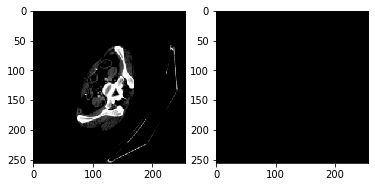

In [5]:
dataset = Nifti_Dataset(mode = "train",dim = 2)
idx = np.random.randint(0,len(dataset))
dataset.show(idx)

In [0]:
def show_slices(dataset,idx = 0,dim = 0,organ_id = None):
  """
  A nice utility function for plotting all of the slices along a given dimension
  idx - indexes all NIfTI images in dataset
  dim - indexes dimension of image
  organ_id - if not None, all other organs removed from label
  """
  data = nib.load(dataset.data_files[idx])
  label = nib.load(dataset.label_files[idx])

  #print(temp.header)
  data = data.get_data()
  data = np.array(data)
  label = label.get_data()
  label = np.array(label)

  for slice in range(0,data.shape[dim]):
    if dim == 0:
          data_slice = data[slice,:,:]
          label_slice = label[slice,:,:]
    elif dim == 1:
      data_slice = data[:,slice,:]
      label_slice = label[:,slice,:]
    elif dim == 2:
      data_slice = data[:,:,slice]
      label_slice = label[:,:,slice]

    if organ_id is not None:
      # if a specific label is to be looked at, 0 all others
      label_slice = 1.0 - np.ceil(np.abs(label_slice.astype(float)-organ_id)/15.0)

    plt.figure()
    plt.subplot(121)
    plt.imshow(data_slice,cmap = "gray")

    plt.subplot(122)
    plt.imshow(label_slice,cmap = "gray")
    plt.show()

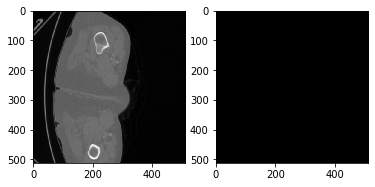

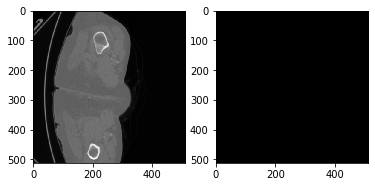

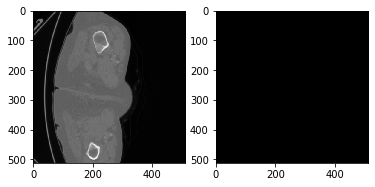

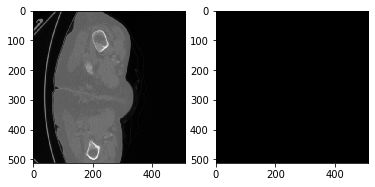

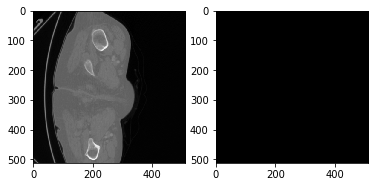

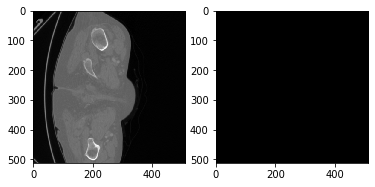

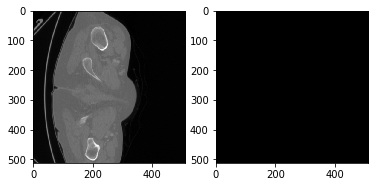

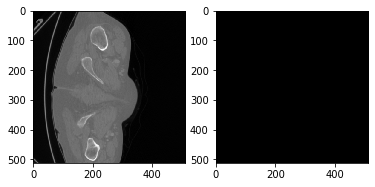

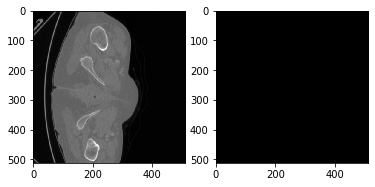

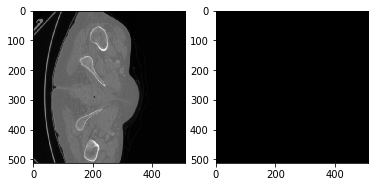

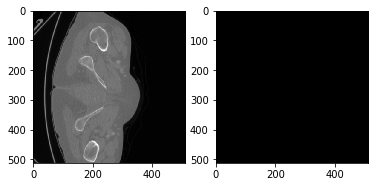

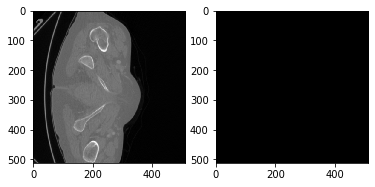

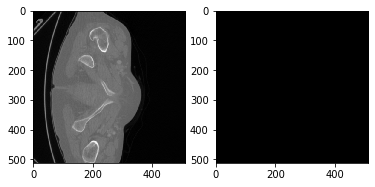

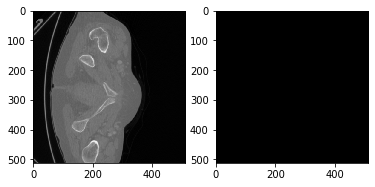

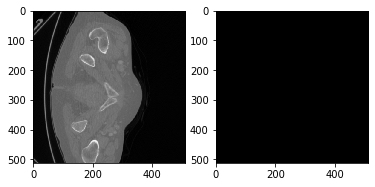

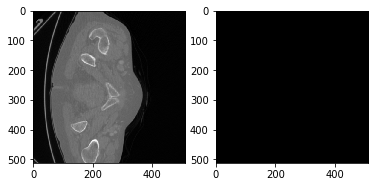

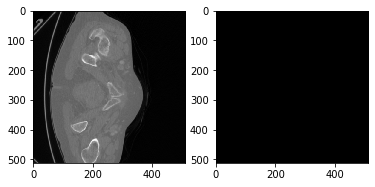

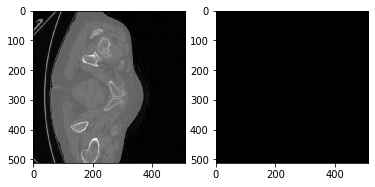

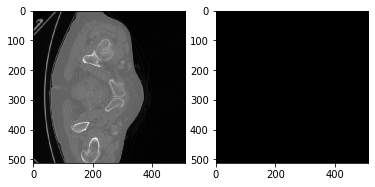

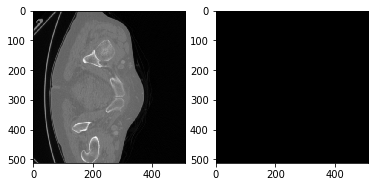

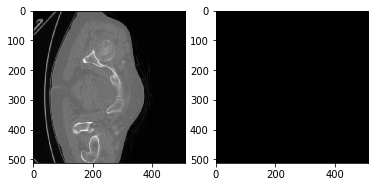

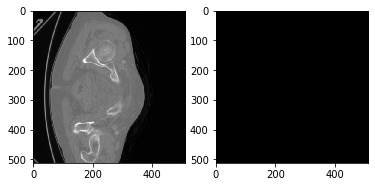

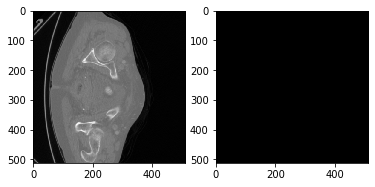

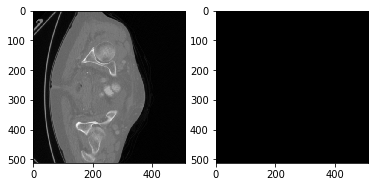

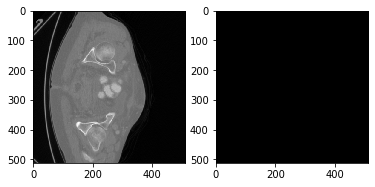

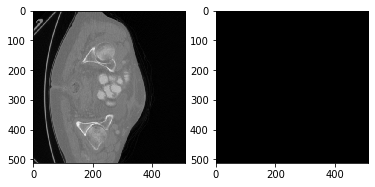

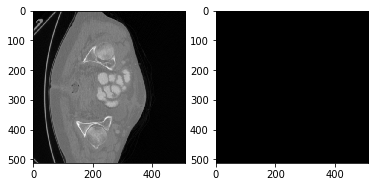

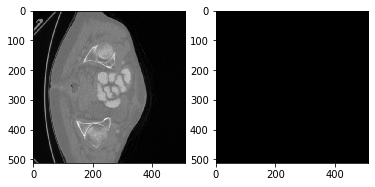

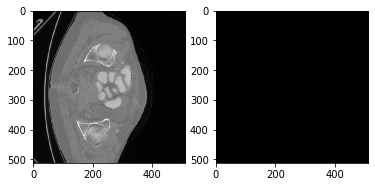

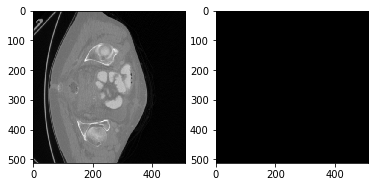

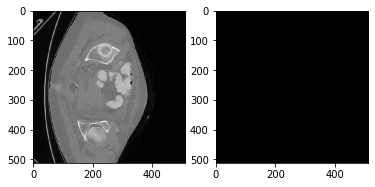

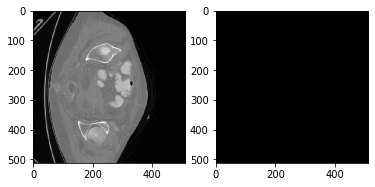

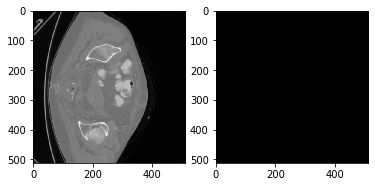

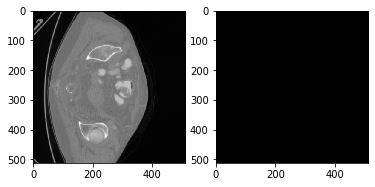

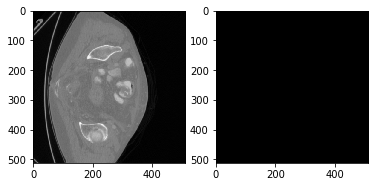

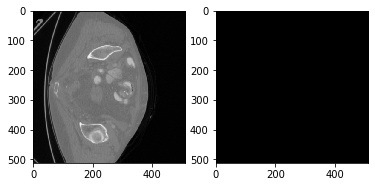

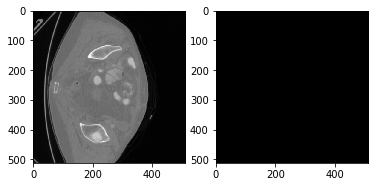

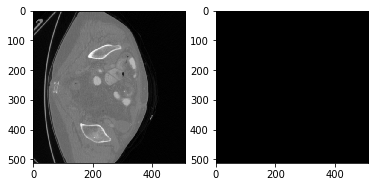

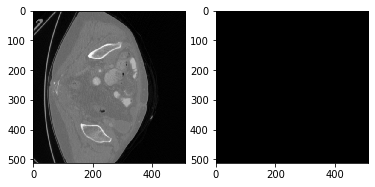

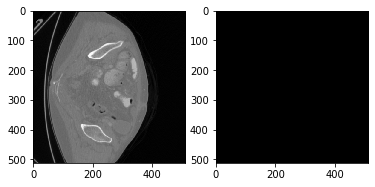

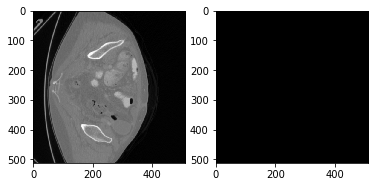

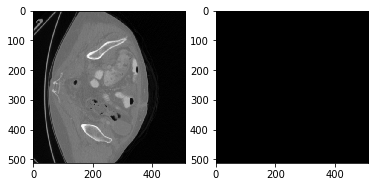

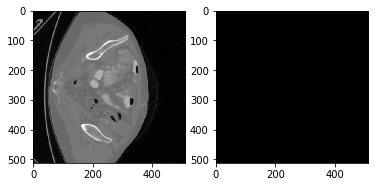

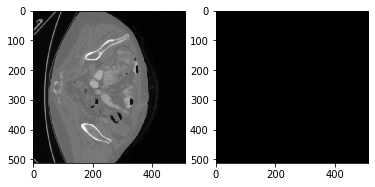

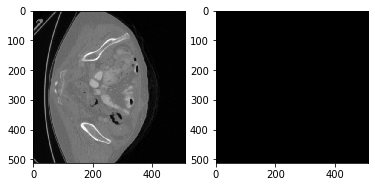

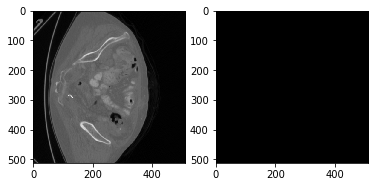

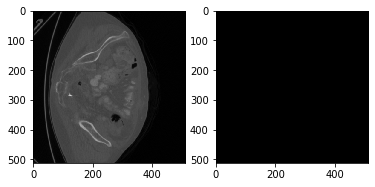

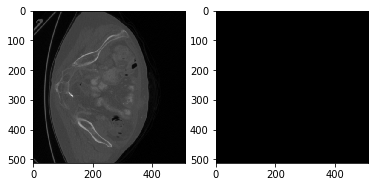

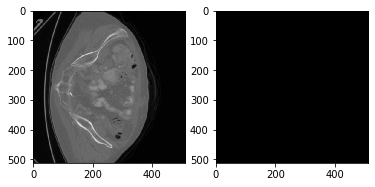

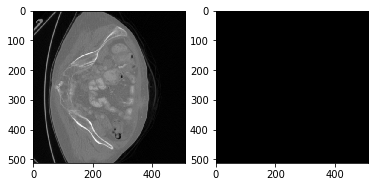

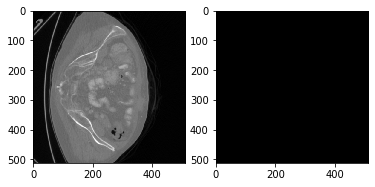

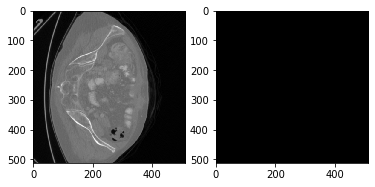

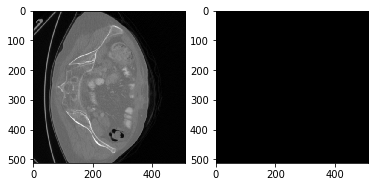

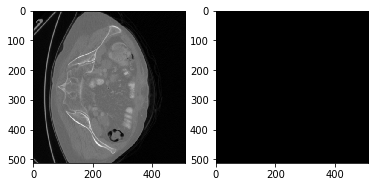

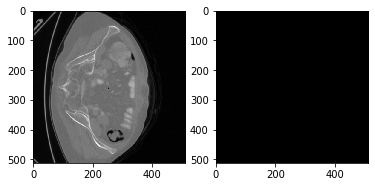

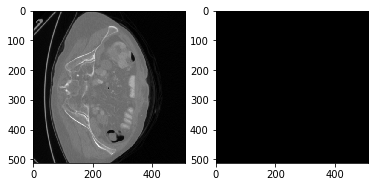

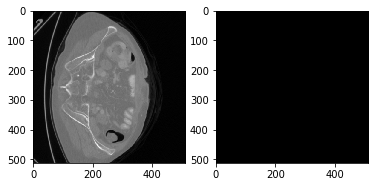

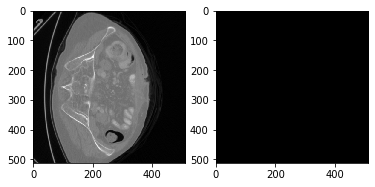

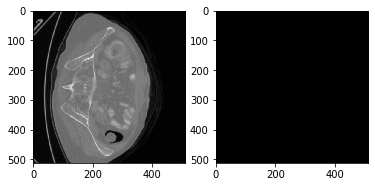

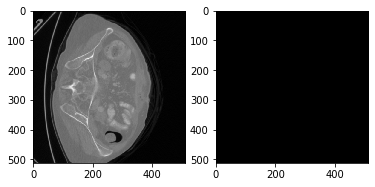

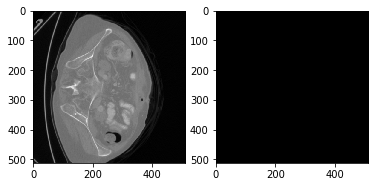

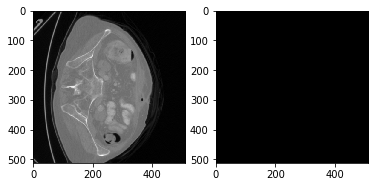

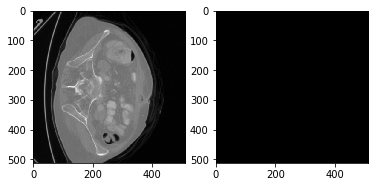

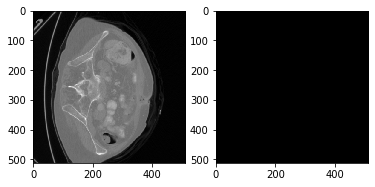

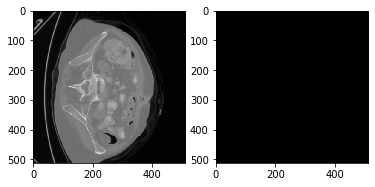

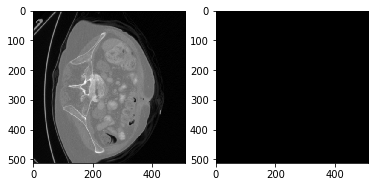

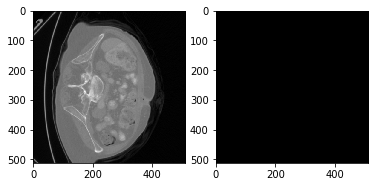

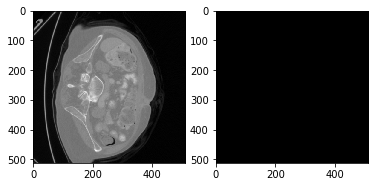

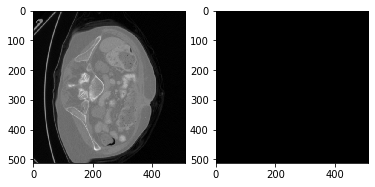

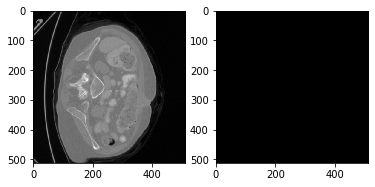

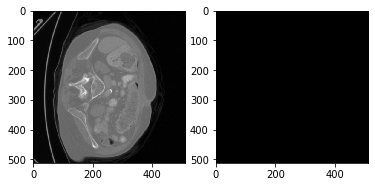

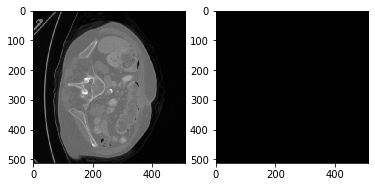

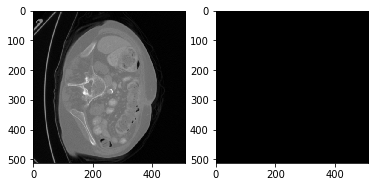

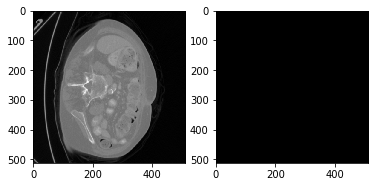

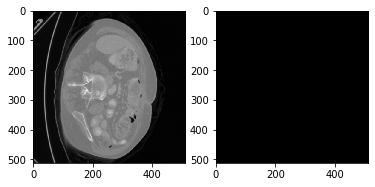

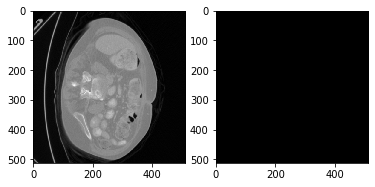

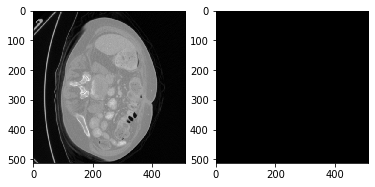

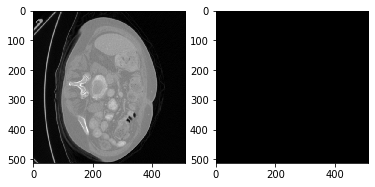

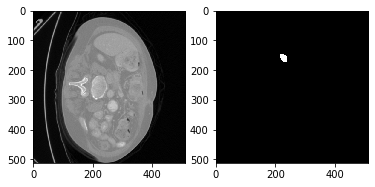

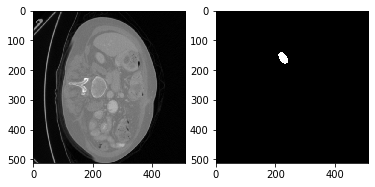

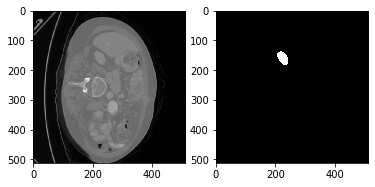

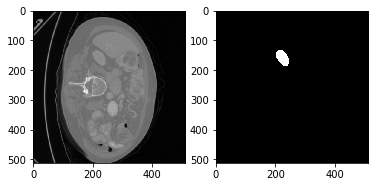

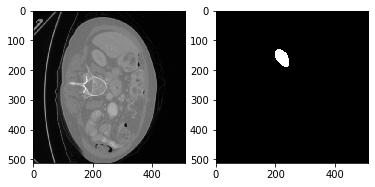

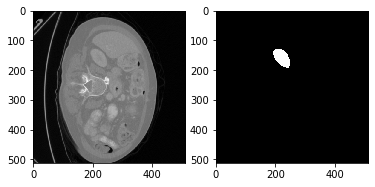

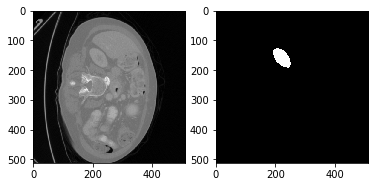

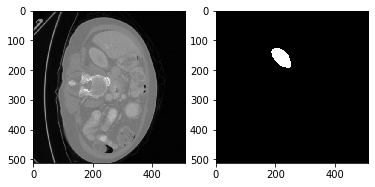

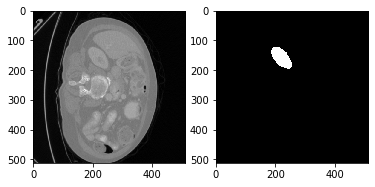

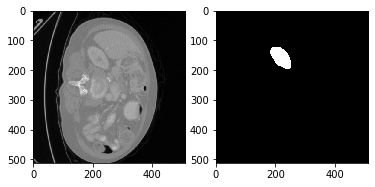

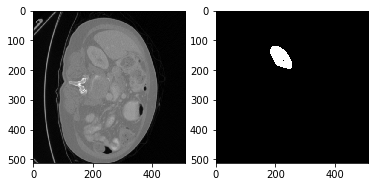

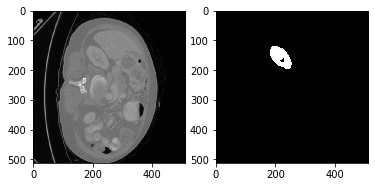

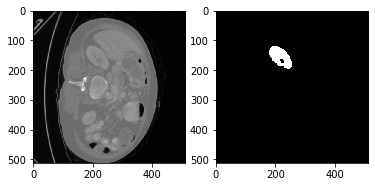

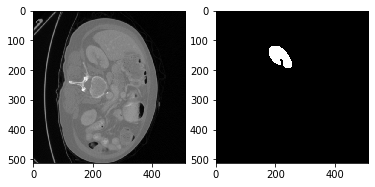

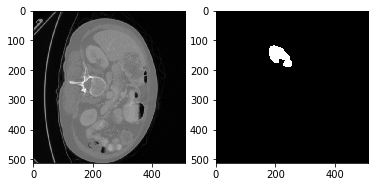

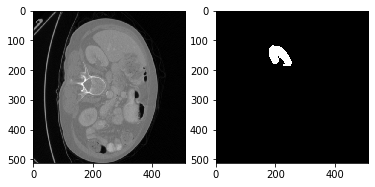

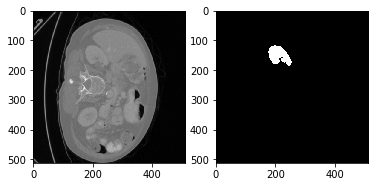

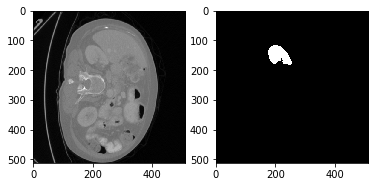

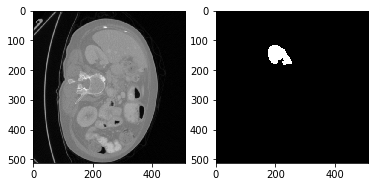

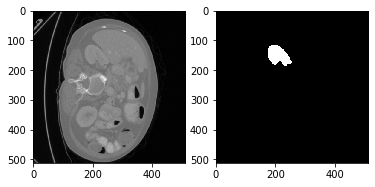

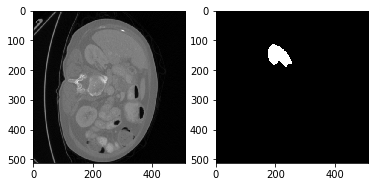

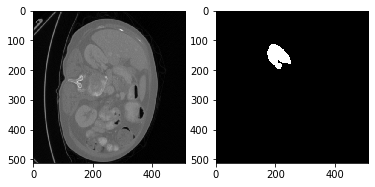

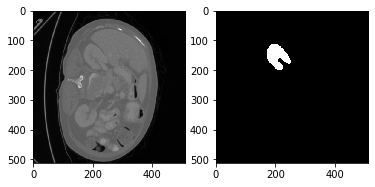

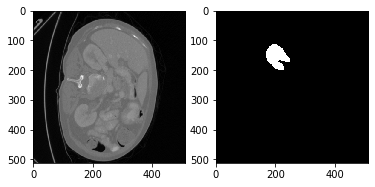

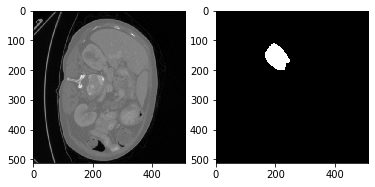

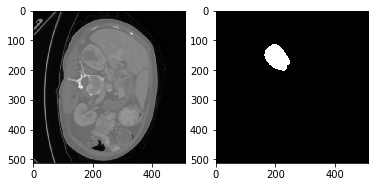

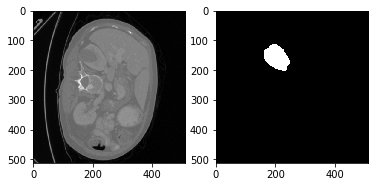

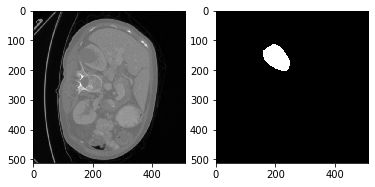

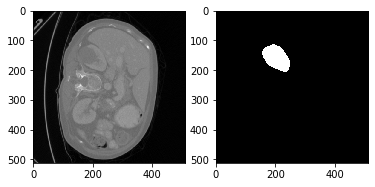

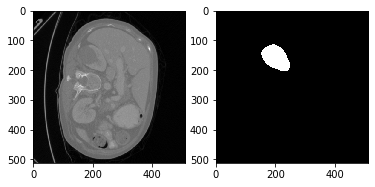

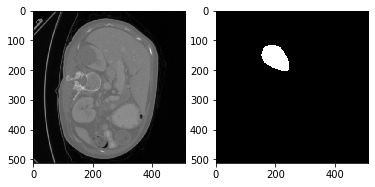

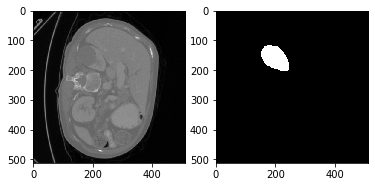

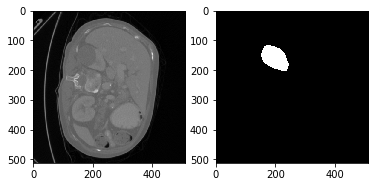

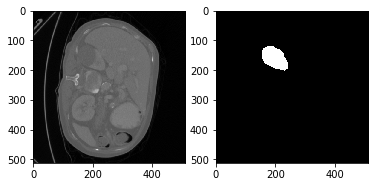

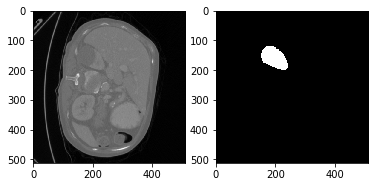

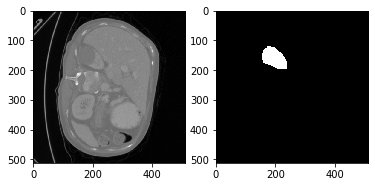

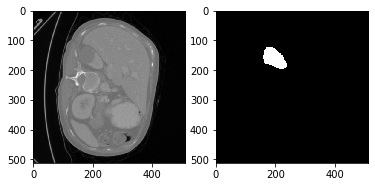

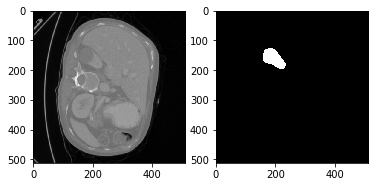

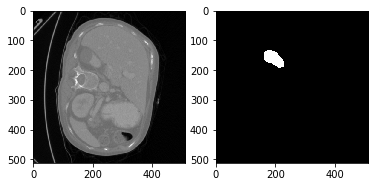

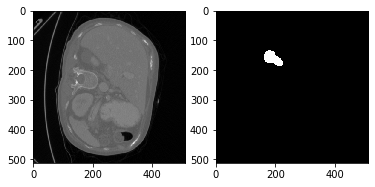

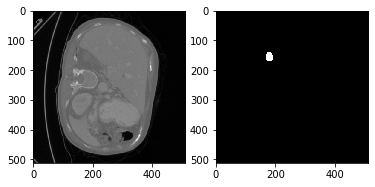

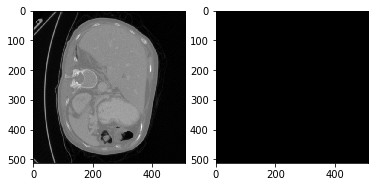

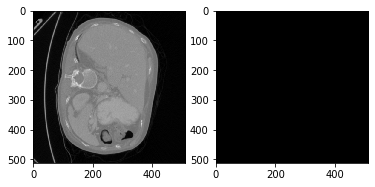

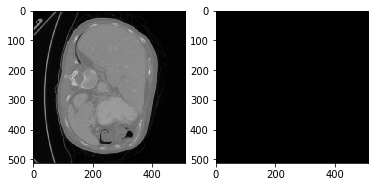

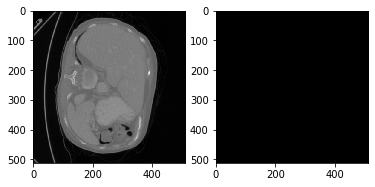

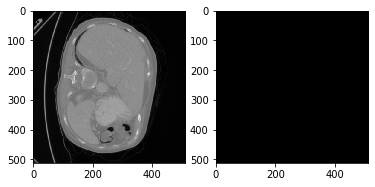

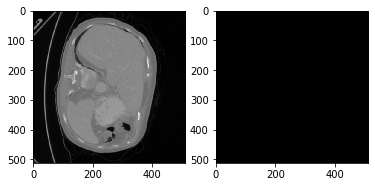

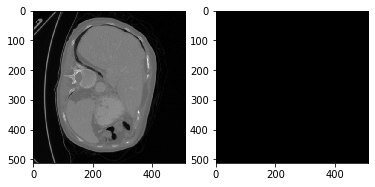

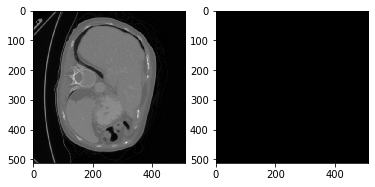

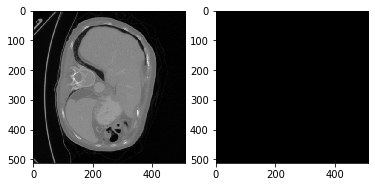

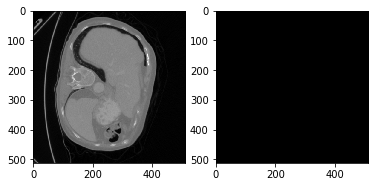

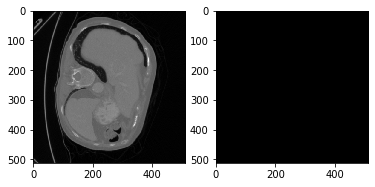

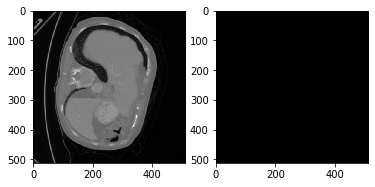

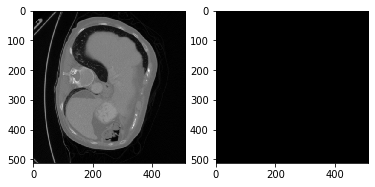

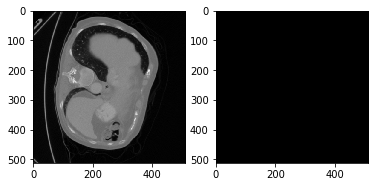

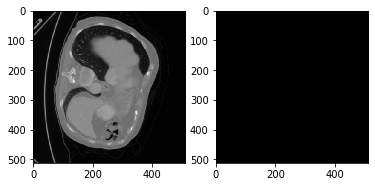

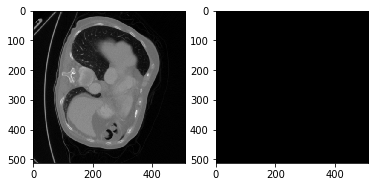

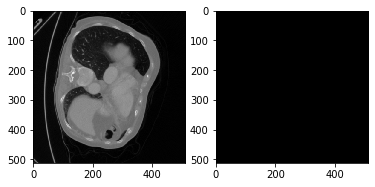

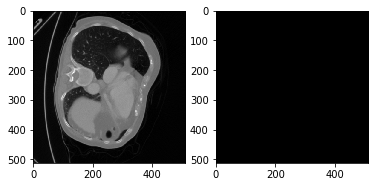

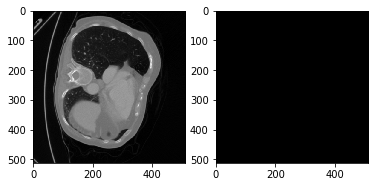

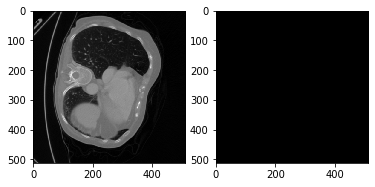

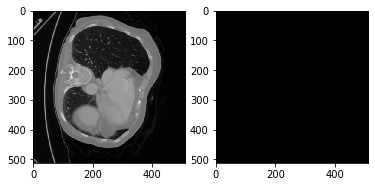

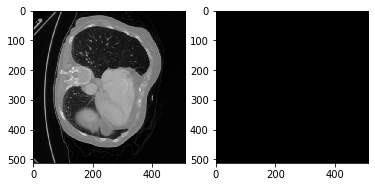

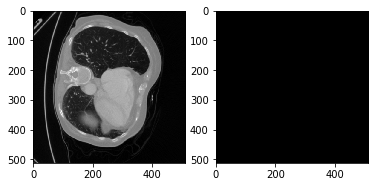

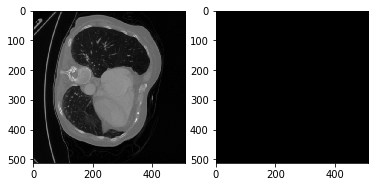

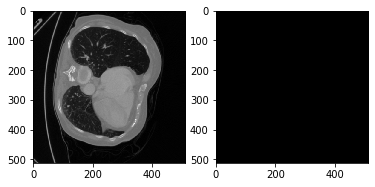

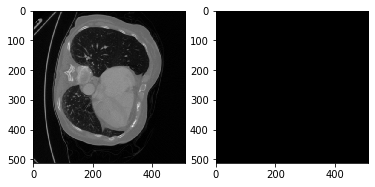

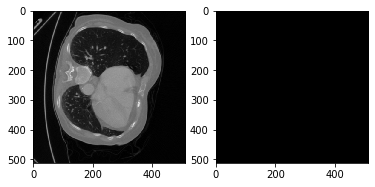

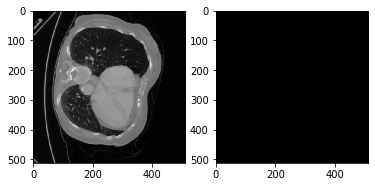

In [7]:
show_slices(dataset,0,dim = 2, organ_id = 2)

## Train U-Net 

Load from Torch.hub and modify slightly for retraining

In [0]:
def test_slice(dataset,model,idx,device):
  x,y = dataset[idx]
  x = x.unsqueeze(0)
  x = x.to(device)

  output = model(x)
  output = output.cpu()
  acc = hard_metric(output,y.unsqueeze(0))
  output = output.data.numpy()
  
  plt.figure()
  plt.subplot(121)
  plt.imshow(output[0][0],cmap = "gray")

  plt.subplot(122)
  plt.imshow(y[0],cmap = "gray")
  plt.show()

  print("Dice Accuracy: {}".format(acc))

In [0]:
def train_model(model, optimizer, scheduler,loss_function,
                    dataset,device, num_epochs=5, start_epoch = 0,
                    all_losses = None,all_accs = None):
        """
        Alternates between a training step and a validation step at each epoch. 
        Validation results are reported but don't impact model weights
        """
        # for storing all metrics
        if all_losses == None:
          all_losses = {
                  'train':[],
                  'val':[]
          }
          all_accs = {
                  "train":[],
                  "val":[]
                  }
        avg_acc = 0
        
        # for early stopping
        best_acc  = 0
        epochs_since_improvement = 0
        
        # create testloader for val_dataset (trainloader is made each epoch)
        params = {'batch_size': 8,
              'shuffle': True,
              'num_workers': 0,
              'drop_last' : True
              }

        for epoch in range(start_epoch,num_epochs):
            print("")

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                  # Set model to training mode
                  model.train()

                  # Step scheduler  
                  if epoch > 0:
                    scheduler.step(avg_acc)

                  # set dataset and dataloader to training mode
                  dataset.mode = "train"
                  loader = data.DataLoader(dataset,**params)
                    
                else:
                    model.eval()   # Set model to evaluate mode
                    dataset.mode = "val"
                    loader = data.DataLoader(dataset,**params)

                count = 0
                total_loss = 0
                total_acc = 0
                # Iterate over data.
                for inputs, targets in loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        
                        # shift targets to 1 0 positive negative labels
                        positive_class = 1
                        targets = 1- torch.ceil(torch.abs((targets.float()-positive_class)/7.0))
                        loss = loss_function(outputs,targets)
                        acc = hard_metric(outputs,targets)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
        
                    # verbose update
                    count += 1
                    total_acc += acc
                    total_loss += loss.item()
                    if count % 20 == 0:
                      print("{} epoch {} batch {} -- Loss: {:03f} -- Accuracy {:02f}".format(phase,epoch,count,loss.item(),acc))
                
                avg_acc = total_acc/count
                avg_loss = total_loss/count
                if epoch % 1 == 0:
                  print("Epoch {} avg {} loss: {:05f}  acc: {}".format(epoch, phase,avg_loss,avg_acc))
                  all_losses[phase].append(total_loss)
                  all_accs[phase].append(avg_acc)

                  # plot an output
                  idx = random.randint(0,len(dataset))
                  test_slice(dataset,model,idx,device)

                  # save a checkpoint
                  PATH = "/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/UNet_{}.pt".format(epoch)
                  torch.save({
                      'epoch': epoch,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      "losses":all_losses,
                      "accs":all_accs
                      }, PATH)
                  
                torch.cuda.empty_cache()
            
            if False:    
              # stop training when there is no further improvement
              if avg_acc > best_acc:
                  epochs_since_improvement = 0
                  best_acc = avg_acc
              else:
                  epochs_since_improvement +=1
              print("{} epochs since last improvement.".format(epochs_since_improvement))
              #if epochs_since_improvement >= 5:
              #    break
                
        return model , all_losses,all_accs

def hard_metric(target,output,epsilon = 1e-07):
  """
  Binary cross entropy gives a continuous approximation of pixelwise iou. 
  This function gives a discrete evaluation based on a cutoff threshold of 0.5
  """

  output = output.round()

  numerator = torch.sum(2*torch.mul(output,target) + epsilon)
  denominator = torch.sum(output + target + epsilon)

  dice = numerator/denominator

  return dice

class Dice_Loss(nn.Module):        
    def __init__(self):
        super(Dice_Loss,self).__init__()
        
    def forward(self,output,target,epsilon = 1e-07):
        """ Compute the bbox iou loss for target vs output using tensors to preserve
        gradients for efficient backpropogation"""
        
        numerator = 2*torch.mul(output,target) + epsilon
        denominator = output + target + epsilon

        dice = torch.sum(numerator)/torch.sum(denominator)

        return 1.0 - dice

def load_model(checkpoint_file,model,optimizer):
  """
  Reloads a checkpoint, loading the model and optimizer state_dicts and 
  setting the start epoch
  """
  checkpoint = torch.load(checkpoint_file)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  all_losses = checkpoint['losses']
  all_accs = checkpoint['accs']

  return model,optimizer,epoch,all_losses,all_accs

In [0]:
if False:
  del dataset
  del model
  torch.cuda.empty_cache()

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Model loaded.
Reloaded checkpoint /content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/UNet_2.pt.
Beginning training on cuda:0.

train epoch 3 batch 20 -- Loss: 0.001004 -- Accuracy 0.998996
train epoch 3 batch 40 -- Loss: 0.000867 -- Accuracy 0.999133
train epoch 3 batch 60 -- Loss: 0.000738 -- Accuracy 0.999262
train epoch 3 batch 80 -- Loss: 0.000714 -- Accuracy 0.999286
train epoch 3 batch 100 -- Loss: 0.000870 -- Accuracy 0.999130
train epoch 3 batch 120 -- Loss: 0.000659 -- Accuracy 0.999341
train epoch 3 batch 140 -- Loss: 0.000652 -- Accuracy 0.999348
train epoch 3 batch 160 -- Loss: 0.000865 -- Accuracy 0.999135
train epoch 3 batch 180 -- Loss: 0.000686 -- Accuracy 0.999314
train epoch 3 batch 200 -- Loss: 0.000599 -- Accuracy 0.999401
train epoch 3 batch 220 -- Loss: 0.000588 -- Accuracy 0.999412
train epoch 3 batch 240 -- Loss: 0.000579 -- Accuracy 0.999421
train epoch 3 batch 260 -- Loss: 0.000593 -- Accuracy 0.999407
train epoch 3 batch 280 -- Loss: 0.000584 --

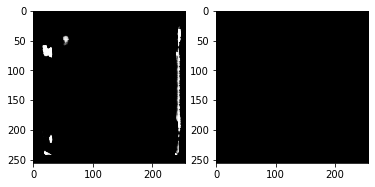

Dice Accuracy: 5.9799222071887925e-06
val epoch 3 batch 20 -- Loss: 0.000502 -- Accuracy 0.999498
val epoch 3 batch 40 -- Loss: 0.000392 -- Accuracy 0.999608
val epoch 3 batch 60 -- Loss: 0.000393 -- Accuracy 0.999607
Epoch 3 avg val loss: 0.000470  acc: 0.9995294809341431


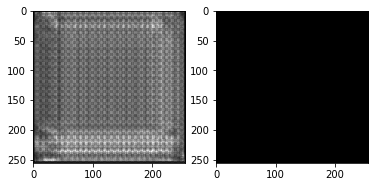

Dice Accuracy: 0.9992967247962952

train epoch 4 batch 20 -- Loss: 0.000578 -- Accuracy 0.999422
train epoch 4 batch 40 -- Loss: 0.000511 -- Accuracy 0.999489
train epoch 4 batch 60 -- Loss: 0.000642 -- Accuracy 0.999358
train epoch 4 batch 80 -- Loss: 0.000435 -- Accuracy 0.999565
train epoch 4 batch 100 -- Loss: 0.000451 -- Accuracy 0.999549
train epoch 4 batch 120 -- Loss: 0.000461 -- Accuracy 0.999539
train epoch 4 batch 140 -- Loss: 0.000437 -- Accuracy 0.999563
train epoch 4 batch 160 -- Loss: 0.000426 -- Accuracy 0.999574
train epoch 4 batch 180 -- Loss: 0.000406 -- Accuracy 0.999594


KeyboardInterrupt: ignored

In [11]:
if __name__ == "__main__":
  dim = 2
  
  try:
      torch.multiprocessing.set_start_method('spawn')    
  except:
      pass

  # CUDA for PyTorch
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")
  torch.cuda.empty_cache()   
  
  #%% Create Model
  try:
    model
  except:
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)
  print ("Model loaded.")
  model = model.to(device)

  #%% Create datasets
  try:
      dataset
  except:
      dataset = Nifti_Dataset(mode = "train", dim = dim)
      print("Loaded dataset on dimension {}".format(dim))

  start_epoch = -1
  num_epochs = 200

  #loss = nn.BCELoss()
  loss = Dice_Loss()

  optimizer = optim.SGD(model.parameters(), lr= 0.03,momentum = 0.1)    
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.3, mode = "min", patience = 2,verbose=True)

  checkpoint = "/content/drive/My Drive/Colab Notebooks/Segmentation/checkpoints/UNet_2.pt"
  
  if checkpoint:
    model,optimizer,start_epoch,all_losses,all_accs = load_model(checkpoint,model, optimizer)
    print("Reloaded checkpoint {}.".format(checkpoint))

  if True:    
  # train model
      print("Beginning training on {}.".format(device))
      model,all_losses,all_accs = train_model(model,  optimizer, scheduler,
                          loss, dataset,device,
                          num_epochs, start_epoch+1,all_losses= None,all_accs= None)

  torch.cuda.empty_cache()  

In [0]:
idx = random.randint(0,len(dataset))
test_slice(dataset,model,idx,device)